## Binary Addition using LSTM

In this notebook, we have trained a LSTM model to add two binary strings of `n` length and output the result as n-length binary string. The main purpose of this implementation is to observe the LSTM hidden state activations for a simple problem and understand its working. 

We started with 2 LSTM layers and 8 nodes each. However, we observed that a single layered LSTM with 3 nodes also suffices to give accurate results for binary strings upto length 8.

In [1]:
%matplotlib inline
import numpy as np
from keras import Sequential
from keras.layers import Dense
import keras.backend as K
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
import pprint
import random as rn

Using TensorFlow backend.


In [2]:
np.random.seed(42) # for reproducibility
tf.set_random_seed(1234)
rn.seed(12345)

In [3]:
pp = pprint.PrettyPrinter(indent=4, depth=4)

### Generating Training Dataset 

In [4]:
binary_dim = 8 # n-length binary string

# Setting highest no. to 256 so that we add atmost 8 digits(2^8)
largest_number = pow(2,binary_dim)

print("Largest number of given binary dimension : " + str(largest_number))

Largest number of given binary dimension : 256


In [5]:
#converting numbers into binary form

int2binary = {}

binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

for i in range(largest_number):
    int2binary[i] = np.flip(np.array(binary[i]))

##### For generating training samples:

We have defined a function `training_generator` for generating training samples of all possible combinations for adding two binary strings for a particular binary input length. We are taking all the cases by adding all the numbers from 0 to half of the largest number to avoid carry overflow cases.

`x_train` has two input binary strings to be added. Thus, it has dimension: <br>
    -  'no_of_possible_samples x binary_length x number_of_inputs'. 
    -  Number of possible samples is dependent on the binary length of the input. Here, we are adding two inputs of 8-bit length. Therefore, binary_length= 8 and number_of_inputs= 2.

`y_train` has the binary representation of the output for each case. Thus, it has dimension: <br>
    -  'no_of_possible_samples x binary_length'

We are flipping the inputs and the outputs, as the RNN/LSTM model will read the input/output from left-to-right whereas binary addition is done from right-to-left.

In [6]:
def training_generator(binary_dim, largest_number):
    x_train = np.array([[np.zeros(binary_dim),np.zeros(binary_dim)]])
    y_train = np.array([np.zeros(binary_dim)])
    
    for i in range(int(largest_number)):
        a_array = int2binary[i]
        
        for j in range(int(largest_number)):
            b_array = int2binary[j]
    
            x = np.array([[a_array,b_array]])
            y = [int2binary[i+j]]
        
            x_train = np.concatenate((x_train, x), axis=0)
            y_train = np.concatenate((y_train, y))
        
    return x_train,y_train

##### Parameters to be set:

In [7]:
nodes = 3   # Number of embedding cells in LSTM 
batch_size = 128
num_epochs = 12
sequence_length = 3    # Length 3 suffices to train all the cases of binary addition

In [8]:
X_train, Y_train = training_generator(binary_dim, largest_number/2.0)
X_train = X_train[:,:,:sequence_length]
X_train = np.transpose(X_train,[0,2,1])

In [9]:
X_train.shape

(16385, 3, 2)

In [10]:
Y_train = Y_train[:,:sequence_length]
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print(Y_train.shape)

(16385, 3, 1)


#### LSTM model:

In [11]:
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

In [12]:
def lstm_model(seq_len=binary_dim, EMBEDDING_DIM=nodes, batch_size=None, stateful=True):
    
    source = tf.keras.Input(shape=(seq_len,2), batch_size=batch_size)
    print(source.shape)

    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(source)
    print(lstm_1.shape)
    
    predicted_digit = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_1)
    print(predicted_digit.shape)
    
    model = tf.keras.Model(inputs=[source], outputs=[predicted_digit,lstm_1])

    model.compile(
      optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
      loss=['binary_crossentropy', zero_loss],
      metrics=['accuracy'])
    return model

In [13]:
tf.keras.backend.clear_session()

digit_model = lstm_model(seq_len=sequence_length, EMBEDDING_DIM=nodes, stateful=False)

(?, 3, 2)
Instructions for updating:
Colocations handled automatically by placer.
(?, 3, 3)
(?, 3, 1)


In [14]:
digit_model.fit(X_train,[Y_train, np.zeros(Y_train.shape)], epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

Train on 14746 samples, validate on 1639 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/12
14746/14746 [==============================] - 3s 217us/sample - loss: 0.6929 - dense_loss: 0.6929 - lstm_loss: 0.0000e+00 - dense_acc: 0.4618 - lstm_acc: 0.7789 - val_loss: 0.6854 - val_dense_loss: 0.6854 - val_lstm_loss: 0.0000e+00 - val_dense_acc: 0.8371 - val_lstm_acc: 1.0000
Epoch 2/12
14746/14746 [==============================] - 3s 172us/sample - loss: 0.5955 - dense_loss: 0.5955 - lstm_loss: 0.0000e+00 - dense_acc: 0.7992 - lstm_acc: 0.8746 - val_loss: 0.4406 - val_dense_loss: 0.4406 - val_lstm_loss: 0.0000e+00 - val_dense_acc: 0.8324 - val_lstm_acc: 0.5680
Epoch 3/12
14746/14746 [==============================] - 3s 170us/sample - loss: 0.3031 - dense_loss: 0.3031 - lstm_loss: 0.0000e+00 - dense_acc: 0.8752 - lstm_acc: 0.5080 - val_loss: 0.2126 - val_dense_loss: 0.2126 - val_lstm_loss: 0.0000e+00 - val_dense_acc: 0.9524 - val_lstm_acc: 0.4816
Epoch 4/12
14746/14746 [===

In [15]:
model_name = 'model_weights/binary_addition_' + str(nodes) + '_nodes_1_layer_seqlen_3.h5'
digit_model.save_weights(model_name, overwrite=True)

### Make predictions with the model

Use the trained model to make predictions. Here, we take two binary input strings and feed the model bit by bit to predict the next bit in the output. The predicted output and the lstm states at each timestep is stored.

In [16]:
def predict(x, binary_dim, prediction_model):
    
    predicted_digit_o = []
    lstm_1_o = []
   
    prediction_model.reset_states()
    
    for i in range(binary_dim):
        [predicted_digit_temp,lstm_1_temp] = prediction_model.predict(x[:, i:i+1 ,:])
        predicted_digit_o.append(predicted_digit_temp[0,0,:])
        lstm_1_o.append(lstm_1_temp[0,0,:])
        
    return predicted_digit_o,lstm_1_o

In [17]:
prediction_model = lstm_model(seq_len=1,EMBEDDING_DIM=nodes, batch_size=1, stateful=True)
prediction_model.load_weights(model_name)

(1, 1, 2)
(1, 1, 3)
(1, 1, 1)


#### LSTM Cell outputs:

To understand the LSTM Cell outputs, we give the input numbers such that their binary representations have all the possible combinations of bit addition that we want to observe.

We can take a = 78, b = 87 and c = (a + b) to observe all the cases.

a =  78 = '0 1 0 0 1 1 1 0' <br>
b =  87 = '0 1 0 1 0 1 1 1' <br>
c = 165 = '1 0 1 0 0 1 0 1' <br>

To view some continous pattern, we can take the inputs as a = 62 and b = 87. 

a =  63 = '1 1 1 1 1 1 0 0' <br>
b = 127 = '1 1 1 1 1 1 1 0' <br>
c = 190 = '0 1 1 1 1 1 0 1' <br>

In [18]:
binary_length_test = 13
x1_test = np.array([0,1,1,1,1,0,0,0,1,1,0,1,0]) # enter input in reverse order (Left- least significant bit)
x2_test = np.array([0,1,1,1,1,0,1,0,0,0,0,1,0])
x_test = np.transpose(np.array([[x1_test, x2_test]]),[0,2,1])
x_test.shape

(1, 13, 2)

In [19]:
# To check carry function 
cin = 0
carry_temp = []
for j in range(binary_length_test):
    a = x1_test[j]
    b = x2_test[j]
    
    carry_out = (a & b) | (cin&(a^b))
    carry_temp.append(carry_out)
    cin = carry_out

print(carry_temp)

[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [20]:
def plot_heatmap_nodes(x_test, binary_length_test, prediction_model):
    
    predicted_digit, lstm_1_o = predict(x_test, binary_length_test, prediction_model)
    lstm_1_arr_3N = np.array(lstm_1_o).T
    predicted_output = np.uint8(np.array(predicted_digit) > 0.5).T[0]
    
    print('Input 1:         ',(x_test[0,:,0]).T)
    print('Input 2:         ',(x_test[0,:,1]).T)
    print('Predicted output:',predicted_output)
    
    labels_x_axis = [x1 + x2 + x3 \
                    for (x1, x2, x3) in zip(np.array(x_test[0,:,0], dtype='str'), \
                    np.array(x_test[0,:,1], dtype='str'), np.array(predicted_output, dtype='str'))]
    plt.figure(figsize=[25,6])
    ax2 = sns.heatmap(lstm_1_arr_3N ,xticklabels=labels_x_axis, vmin=-1, vmax=1)
    # Loop over data dimensions and create text annotations.

#### Sample Examples:

Here, the input and the output binary strings are to be read from left to right i.e. the left most bit is the least significant bit. The flipping of the bits was done so that the LSTM model processes the inputs in correct sequence.

Input 1:          [0 1 1 1 1 0 0 0 1 1 0 1 0]
Input 2:          [0 1 1 1 1 0 1 0 0 0 0 1 0]
Predicted output: [0 0 1 1 1 1 1 1 0 0 1 0 1]


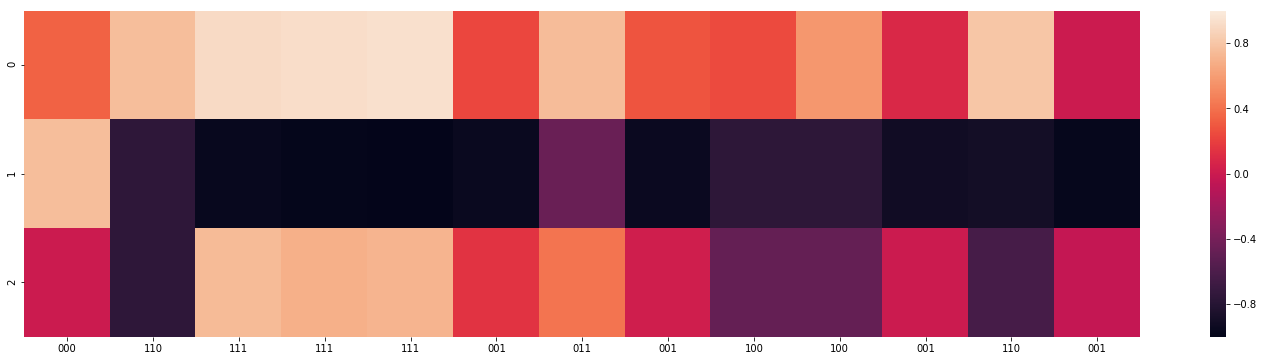

In [21]:
plot_heatmap_nodes(x_test, binary_length_test, prediction_model)

In [22]:
randBinList = lambda n: [rn.randint(0,1) for b in range(n)]

In [23]:
### For random sample examples:

num_examples = 10
max_length = 16 

x_test = []
predicted_output = []
lstm_1_arr_3N = []
carry = []
sum_bit = []

for i in range(num_examples):
    
    # Generating random input strings of random length (Max-16)
    length = rn.randint(1,max_length)
    x1_test = np.flip(np.concatenate((np.zeros(max_length-length, dtype='int'), np.array(randBinList(length),dtype='int')))) # Padding with zeroes
    x2_test = np.flip(np.concatenate((np.zeros(max_length-length, dtype='int'), np.array(randBinList(length),dtype='int')))) # Padding with zeroes
    
    x_test_temp = np.transpose(np.array([[x1_test, x2_test]]),[0,2,1])
    x_test.append(x_test_temp)
    
    # Storing the actual values of sum and carry for each example 
    cin = 0
    carry_temp = []
    sum_bit_temp = []
    
    for j in range(max_length):
        a = x1_test[j]
        b = x2_test[j]
    
        carry_out = (a & b) | (cin&(a^b))
        carry_temp.append(carry_out)
        cin = carry_out
        
        sum_bit_out = (a^b^cin)
        sum_bit_temp.append(sum_bit_out)
        
    carry.append(carry_temp)
    sum_bit.append(sum_bit_temp)
    
    # Predicting the addition sum
    predicted_digit, lstm_1_o = predict(x_test_temp, max_length, prediction_model)
    lstm_1_arr_3N.append(np.array(lstm_1_o))
    predicted_output.append(np.uint8(np.array(predicted_digit) > 0.5).T[0])

x_test = np.squeeze(np.array(x_test), axis=1)

In [24]:
carry = np.array(carry)
carry.shape

(10, 16)

In [25]:
sum_bit = np.array(sum_bit)
sum_bit.shape

(10, 16)

In [26]:
lstm_1_arr_3N = np.array(lstm_1_arr_3N)
lstm_1_arr_3N.shape

(10, 16, 3)

In [27]:
def plot_general_heatmap(lstm_node, num_examples, max_length, sum_bit, carry):
    
    fig, ax = plt.subplots()
    im = ax.imshow(np.fliplr(lstm_node), cmap='magma', vmin=-1, vmax=1, aspect='auto')
    plt.colorbar(im)
    ax.set_xticks(np.arange(max_length))
    ax.set_yticks(np.arange(num_examples))

    for i in range(num_examples):
        for j in range(max_length):
            str_text = str(sum_bit[i, j]) + str(carry[i, j])
            text = ax.text(max_length-1-j, i, str_text,
                       ha="center", va="center", color="w")

    ax.set_title("Heatmap of LSTM node activation")
    fig.tight_layout()
    plt.show()

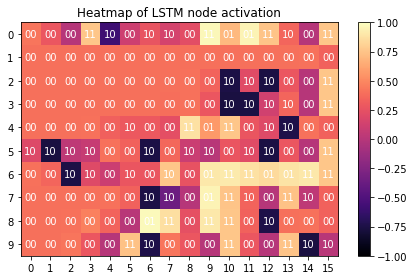

In [28]:
# LSTM Node 1
plot_general_heatmap(lstm_1_arr_3N[:,:,0], num_examples, max_length, sum_bit, carry)

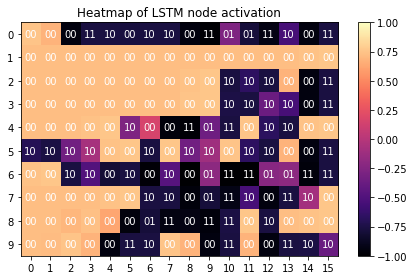

In [29]:
# LSTM Node 2
plot_general_heatmap(lstm_1_arr_3N[:,:,1], num_examples, max_length, sum_bit, carry)

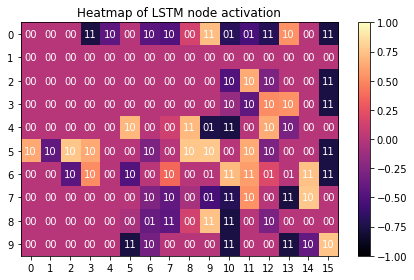

In [30]:
# LSTM Node 3
plot_general_heatmap(lstm_1_arr_3N[:,:,2], num_examples, max_length, sum_bit, carry)